In [643]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

import seaborn as sns
sns.set_style('whitegrid')

import torch
import torch.nn as nn

from ta.volume import VolumeWeightedAveragePrice
from ta.momentum import ROCIndicator
from ta.momentum import RSIIndicator
from ta.momentum import StochRSIIndicator

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# project modules
import importlib
import model
from data_processing import create_loaders
from data_processing import normalize_data
from data_processing import split_to_sequences
from training import train_model
from training import predict
from visualization import plot_losses
from visualization import draw_prediction
from positional import PositionalEncoding
from positional import Time2Vector
from data_generator import generate_df

# importlib.reload(pos)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1121]:
# Load data
stock_list = ['NFLX', 'EPAM', 'AAPL']

end = datetime.now()
start = datetime(end.year - 3, end.month, end.day)

for stock in stock_list:
    globals()[stock] = yf.download(stock, start, end)

stock_data = [NFLX, EPAM, AAPL]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [1122]:
# generate test dataset
generated_df = generate_df()
generated_df["Adj Close"] = generated_df["views"]
data_len = len(generated_df)
print(f"Dataset size: {data_len}")
print(generated_df.head())

Dataset size: 731
   timestamp  index  amplitude    offset     views  Adj Close
0 2018-01-01      0   0.292210 -0.567950 -0.691064  -0.691064
1 2018-01-02      1   0.290693 -0.547809 -0.653927  -0.653927
2 2018-01-03      2   0.289176 -0.524255 -0.406221  -0.406221
3 2018-01-04      3   0.287659 -0.498044 -0.366301  -0.366301
4 2018-01-05      4   0.286143 -0.470019 -0.369968  -0.369968


<AxesSubplot:xlabel='timestamp'>

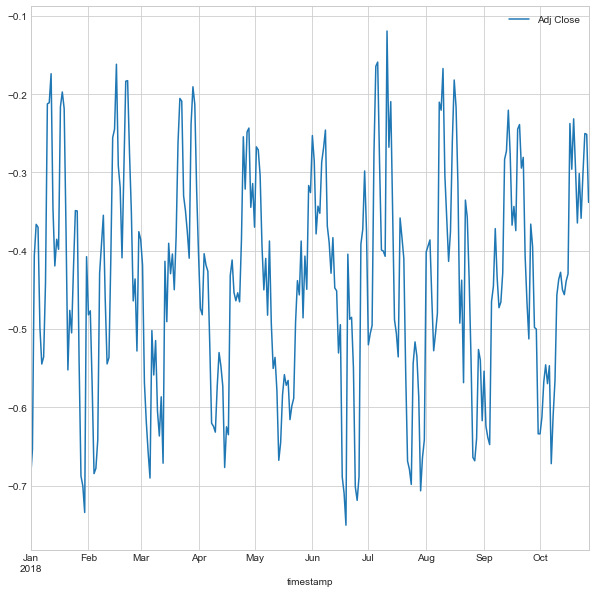

In [1123]:
generated_df[:300].plot(x="timestamp", y="Adj Close",
        kind="line", figsize=(10, 10))

In [1129]:
data = EPAM
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-08-23,194.110001,195.889999,187.330002,188.240005,188.240005,468500
2019-08-26,190.360001,191.419998,187.479996,188.970001,188.970001,349700
2019-08-27,190.339996,190.529999,185.759995,188.899994,188.899994,370800
2019-08-28,188.179993,190.119995,184.479996,189.750000,189.750000,219800
2019-08-29,192.770004,194.279999,191.080002,191.979996,191.979996,206600


In [471]:
def plot_stocks_data(columns, title = "", x_label = None, y_label = None):
    fig = plt.figure(figsize=(15, 6))
    for i, stock in enumerate(stock_data, 1):
        ax = fig.add_subplot(2, 2, i)
        stock[columns].plot(ax=ax)
        plt.ylabel(y_label)
        plt.xlabel(x_label)
        plt.title(f"{title} {stock_list[i - 1]}")
    
    fig.tight_layout()

In [472]:
def plot_stock_data(stock, collumns, title = "", x_label = None, y_label = None):
    fig = plt.figure(figsize=(15, 6))
    stock[collumns].plot()
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    
    fig.tight_layout()

In [473]:
def plot_stock_data_distribution(column, title = "", x_label = None, y_label = None):
    fig = plt.figure(figsize=(15, 6))
    for i, stock in enumerate(stock_data, 1):
        ax = fig.add_subplot(2, 2, i)
        stock[column].hist(bins=50)
        plt.ylabel(y_label)
        plt.xlabel(x_label)
        plt.title(f"{title} {stock_list[i - 1]}")
    plt.tight_layout()

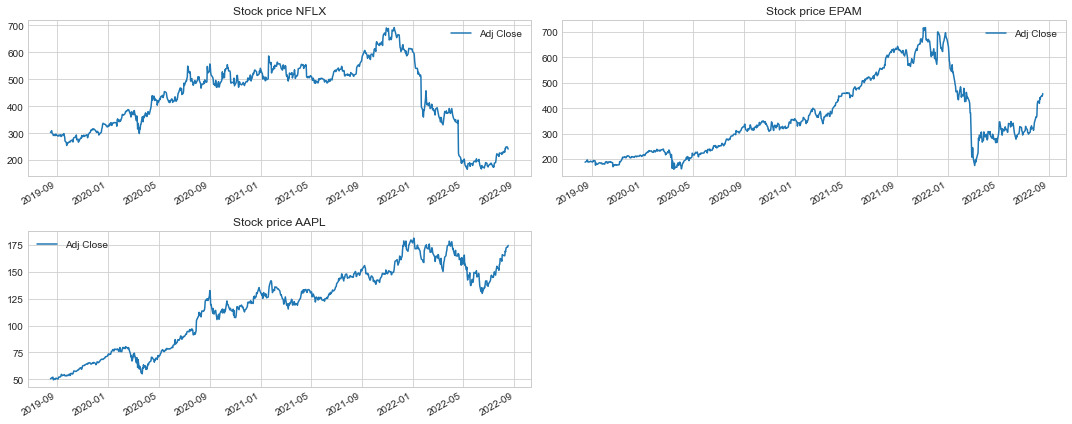

In [474]:
# Plot stock market prices
plot_stocks_data(["Adj Close"], "Stock price")

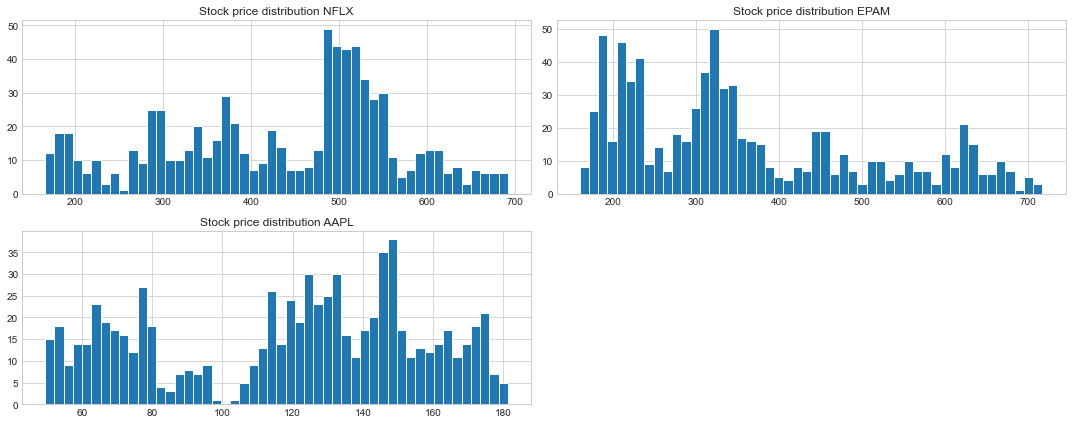

In [475]:
# Plot stock market price distibution
plot_stock_data_distribution("Adj Close", "Stock price distribution")

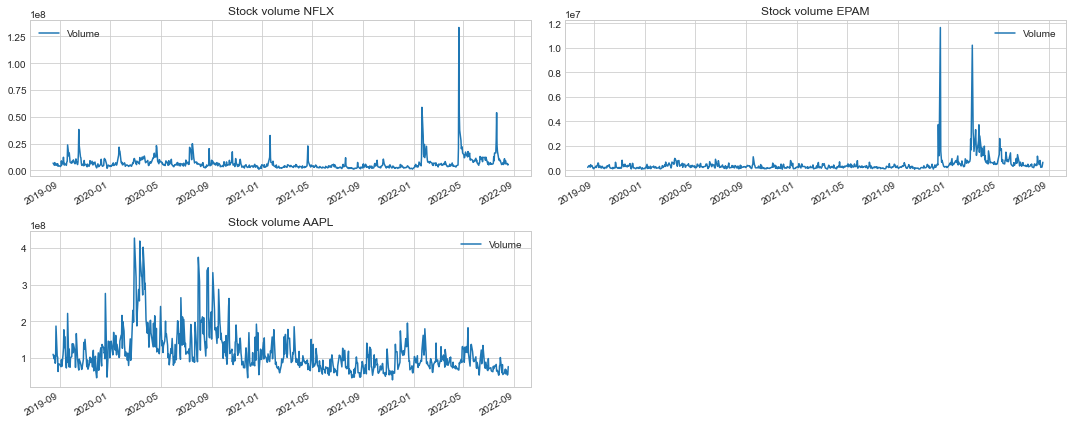

In [476]:
# Plot stock market volume
plot_stocks_data(["Volume"], "Stock volume")

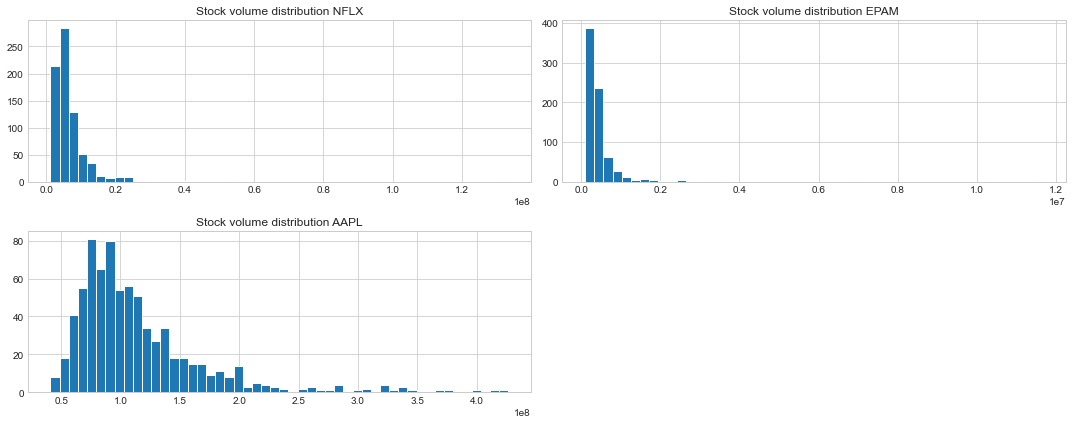

In [477]:
# Plot stock market volume distibution
plot_stock_data_distribution("Volume", "Stock volume distribution")

In [478]:
for i, stock in enumerate(stock_data, 1):
    std = stock["Volume"].std()
    name = stock_list[i-1]
    print(f"{name} stock volume std: {std}")

NFLX stock volume std: 7262611.711497308
EPAM stock volume std: 720052.032019472
AAPL stock volume std: 55959087.71525259


## Feature engenering

**TODO**: add description for about feature engenering, why do we need them and which one is better to have, attach articles links if needed.

### Exponential smoothing

In [479]:
# Exponential smoothing
alphas = [0.1, 0.3, 0.5, 0.9]

for alpha in alphas:
    for stock in stock_data:
        column_name = f"EWM_{alpha}"
        stock[column_name] = stock['Adj Close'].ewm(alpha=alpha, adjust=False).mean()

for stock in stock_data:
    column_name = f"EWM"
    stock[column_name] = stock['Adj Close'].ewm(span=9, adjust=False).mean()

<Figure size 1080x432 with 0 Axes>

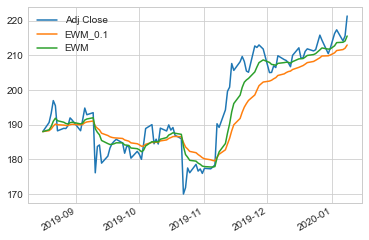

In [480]:
plot_stock_data(EPAM[:100], ['Adj Close', 'EWM_0.1', 'EWM'])

### Volume Weighted Average Price (VWAP)

In [481]:
for stock in stock_data:
    vwap = VolumeWeightedAveragePrice(
        high=stock['High'],
        low=stock['Low'],
        close=stock['Adj Close'],
        volume=stock['Volume'],
        window=9)
    stock['VWAP'] = vwap.volume_weighted_average_price()

<Figure size 1080x432 with 0 Axes>

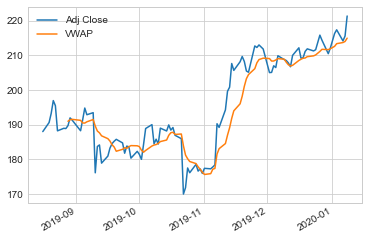

In [482]:
plot_stock_data(EPAM[:100], ['Adj Close', 'VWAP'])

### Momentum

In [483]:
for stock in stock_data:
    indicator_roc = ROCIndicator(close=stock['Adj Close'])
    indicator_rci = RSIIndicator(close=stock['Adj Close'])
    indicator_srci = StochRSIIndicator(close=stock['Adj Close'])
    stock['ROC'] = indicator_roc.roc()
    stock['RSI'] = indicator_rci.rsi()
    stock['SRSI'] = indicator_srci.stochrsi()

<Figure size 1080x432 with 0 Axes>

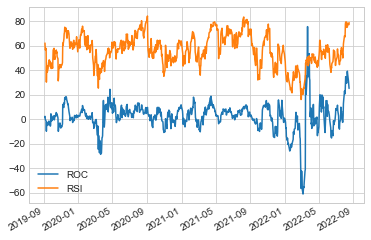

In [484]:
plot_stock_data(EPAM, ['ROC', 'RSI'])

<Figure size 1080x432 with 0 Axes>

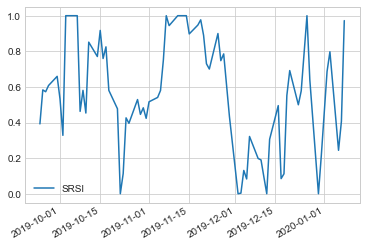

In [485]:
plot_stock_data(EPAM[:100], ['SRSI'])

### Return

In [486]:
for stock in stock_data:
    stock['Return'] = stock['Adj Close'].pct_change()
    stock['Return Log'] = np.log(1 + stock['Return'])

<Figure size 1080x432 with 0 Axes>

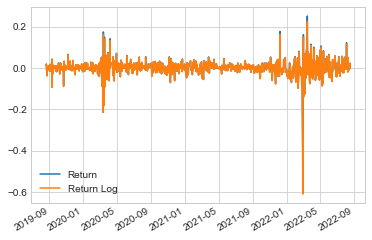

In [487]:
plot_stock_data(EPAM, ['Return', 'Return Log'])

### Return Normalization

In [488]:
# limit return
upper_bound = 0.25
lower_bound = -upper_bound  
def return_normalization(x):
    x = x if x < upper_bound else upper_bound
    x = x if x > lower_bound else lower_bound
    
    # scale value to range from -0.5 to 0.5
    x = x * 2
    return round(x + 0.5, 2)

for stock in stock_data:
    stock['Return Norm'] = stock['Return'].apply(return_normalization)

### Volume normalization

In [498]:
def scale_data(values, scaler):
    data = values.to_numpy().reshape(-1, 1)
    scaler.fit(data)
    data = scaler.transform(data)
    return data.reshape(1, -1)[0]

df = pd.DataFrame(data={
    "a": [1, 2, 3, 4, 5, 6, 7, 8, 9]
})
scaler = MinMaxScaler()
print(scale_data(df["a"], scaler))

[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]


### Feature correlation

<AxesSubplot:>

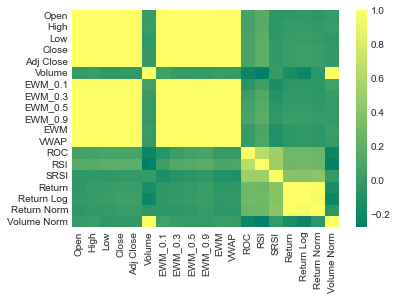

In [491]:
sns.heatmap(EPAM.corr(), cmap='summer')

In [492]:
print(data.shape)
data.dropna(how='any', axis=0, inplace=True)
print(data.shape)
print(data.head)

(757, 19)
(731, 19)
<bound method NDFrame.head of                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-09-24  186.199997  187.899994  180.660004  181.779999  181.779999   
2019-09-25  182.000000  184.559998  179.399994  183.830002  183.830002   
2019-09-26  183.119995  184.880005  182.509995  183.639999  183.639999   
2019-09-27  184.910004  185.279999  179.000000  180.360001  180.360001   
2019-09-30  180.539993  183.399994  179.690002  182.320007  182.320007   
...                ...         ...         ...         ...         ...   
2022-08-11  444.000000  445.630005  434.119995  435.609985  435.609985   
2022-08-12  439.630005  446.940002  433.149994  444.910004  444.910004   
2022-08-15  438.140015  451.480011  435.989990  448.529999  448.529999   
2022-08-16  442.190002  451.239990  442.029999  447.500000  447.500000   
2022-08-17  440.000000  457.959991  439.970001  457.950012  45

In [493]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2019-09-24 to 2022-08-17
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         731 non-null    float64
 1   High         731 non-null    float64
 2   Low          731 non-null    float64
 3   Close        731 non-null    float64
 4   Adj Close    731 non-null    float64
 5   Volume       731 non-null    int64  
 6   EWM_0.1      731 non-null    float64
 7   EWM_0.3      731 non-null    float64
 8   EWM_0.5      731 non-null    float64
 9   EWM_0.9      731 non-null    float64
 10  EWM          731 non-null    float64
 11  VWAP         731 non-null    float64
 12  ROC          731 non-null    float64
 13  RSI          731 non-null    float64
 14  SRSI         731 non-null    float64
 15  Return       731 non-null    float64
 16  Return Log   731 non-null    float64
 17  Return Norm  731 non-null    float64
 18  Volume Norm  731 non-null    fl

In [494]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume,EWM_0.1,EWM_0.3,EWM_0.5,EWM_0.9,EWM,VWAP,ROC,RSI,SRSI,Return,Return Log,Return Norm,Volume Norm
count,731.000000,731.000000,731.000000,731.000000,731.000000,7.310000e+02,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,365.241929,371.554555,358.822846,365.256102,365.256102,4.788833e+05,362.583919,364.426428,364.891039,365.214750,363.895258,363.488143,2.273104,56.293328,0.552800,0.002034,0.001242,0.504774,0.602750
std,147.054668,148.267202,145.162032,146.597236,146.597236,7.318700e+05,144.758230,146.023941,146.310084,146.549899,145.690133,146.799548,12.534887,12.886359,0.343548,0.038272,0.040854,0.071070,2.861102
min,163.210007,168.630005,151.970001,160.130005,160.130005,9.700000e+04,179.551544,171.824624,168.380347,162.666042,175.247215,171.156937,-61.189192,15.942280,0.000000,-0.456763,-0.610210,0.000000,-0.890149
25%,234.480003,238.029999,231.389999,235.000000,235.000000,2.328000e+05,232.866341,234.305316,234.798497,234.841891,233.761524,233.674766,-2.005534,48.050597,0.265620,-0.013131,-0.013218,0.470000,-0.359265
50%,327.820007,333.519989,321.859985,326.920013,326.920013,3.246000e+05,325.421800,325.367581,325.434069,326.013449,324.881801,324.809655,3.004965,56.526227,0.583544,0.002018,0.002016,0.500000,-0.000391
75%,459.524994,463.785004,453.650009,459.289993,459.289993,4.945000e+05,464.784444,458.900263,458.850557,459.085846,459.962947,457.429233,8.115501,65.835138,0.878753,0.017557,0.017405,0.535000,0.663800
max,725.400024,725.400024,711.650024,717.489990,717.489990,1.166500e+07,668.856798,703.708594,712.961183,717.004214,692.738118,689.204143,75.429055,84.080663,1.000000,0.251866,0.224636,1.000000,44.332682


## Data split

Validation and forecase horizon will be a month, there are 21 traiding day in month in average. All the other days data will be used for model training.

**TODO:** add image explaining intervals. Example: https://miro.medium.com/max/1400/1*B0Ll7tyk-BYvU7k403aakA.png

In [1124]:
valid_len = 105 # in days
test_len = 105 # in days
train_len = 7 # in days

**TODO:** add description about day splitting from this article https://www.rasgoml.com/feature-engineering-tutorials/scikit-learn-time-series-split

In [496]:
min_date = data.index.min()
max_date = data.index.max()
valid_start_date = data.index[-valid_len-test_len]
test_start_date = data.index[-test_len]

In [501]:
df = pd.DataFrame(data={
    "a": [1, 2, 3, 4, 5, 6, 7, 8, 9],
    "b": [10, 20, 30, 40, 50, 60, 70, 80, 90],
    "c": [100, 200, 300, 400, 500, 600, 700, 800, 900]
})
scalers = [
    (["a"], MinMaxScaler()),
    (["b", "c"], MinMaxScaler())
]
features_df = normalize_data(df, scalers, True)
print(features_df.head())

Transform columns ['a']
Transform columns ['b', 'c']
       a         b         c
0  0.000  0.000000  0.101124
1  0.125  0.011236  0.213483
2  0.250  0.022472  0.325843
3  0.375  0.033708  0.438202
4  0.500  0.044944  0.550562


In [502]:
df = pd.DataFrame(data={
    "a": [1, 2, 3, 4, 5, 6, 7, 8, 9],
    "b": [10, 20, 30, 40, 50, 60, 70, 80, 90]
})
X, y = split_to_sequences(df, 3, 1, "b")
print(f"X: {X[0]}")
print(f"y: {y[0]}")

X: [[ 1 10]
 [ 2 20]
 [ 3 30]]
y: [40]


## Positional encoding

**TODO**: add description for positional and time2vector encoders, attach articles links if needed.

In [503]:
# Positinal encoder parameters
batch = 10
seq_len = 5
feature_num = 4

# Positinal encoder input
input = torch.randn(batch, seq_len, feature_num)
print(f"Input: {input.shape}")

Input: torch.Size([10, 5, 4])


In [504]:
# Positional encoder test
posEncoder = PositionalEncoding(feature_num, seq_len, True)
output = posEncoder(input)
print(f"Output: {output.shape}")

Output: torch.Size([10, 5, 4])


In [505]:
# Time to vector encoder test
time2vecEncoder = Time2Vector(feature_num, seq_len)
output = time2vecEncoder(input)
print(f"Output: {output.shape}")

Output: torch.Size([10, 5, 8])


## Data normalization

In [507]:
# Robust scaler
robustScalerData = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]

robustScaler = RobustScaler()
robustScaler.fit(robustScalerData)
print(robustScaler.transform(robustScalerData))

[[-1. ]
 [-0.8]
 [-0.6]
 [-0.4]
 [-0.2]
 [ 0. ]
 [ 0.2]
 [ 0.4]
 [ 0.6]
 [ 0.8]
 [ 1. ]]


In [508]:
# Min max scaler
minMaxData = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]

minMaxScaler = MinMaxScaler()
minMaxScaler.fit(minMaxData)
print(minMaxScaler.scale_)
print(minMaxScaler.transform(minMaxData))

[0.1]
[[0. ]
 [0.1]
 [0.2]
 [0.3]
 [0.4]
 [0.5]
 [0.6]
 [0.7]
 [0.8]
 [0.9]
 [1. ]]


In [509]:
# Standard scaler
standardData = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]

standardScaler = StandardScaler()
standardScaler.fit(standardData)
print(standardScaler.mean_)
print(standardScaler.transform(standardData))

[5.]
[[-1.58113883]
 [-1.26491106]
 [-0.9486833 ]
 [-0.63245553]
 [-0.31622777]
 [ 0.        ]
 [ 0.31622777]
 [ 0.63245553]
 [ 0.9486833 ]
 [ 1.26491106]
 [ 1.58113883]]


### Convolution

In [888]:
input = torch.randn(32, 7, 1)

conv = nn.Conv1d(7, 32, 2)
pool = nn.MaxPool1d(2)
output = conv(input)
print(output.shape)
output = pool(output)
print(output.shape)

RuntimeError: Calculated padded input size per channel: (1). Kernel size: (2). Kernel size can't be greater than actual input size

## Training

**TODO:** take concept about training and validation from the article
https://towardsdatascience.com/forecasting-stock-prices-using-exponential-smoothing-b37dfe54e8e9

In [1117]:
# Data columns
print(data.columns)
# target_column = "Adj Close"
# feature_columns = ["Adj Close", "Volume"]
target_column = "Adj Close"
feature_columns = ["Adj Close"]

# Scalers
scalers = [
    (["Adj Close"], MinMaxScaler()),
    # (["Volume"], MinMaxScaler()),
]

Index(['timestamp', 'index', 'amplitude', 'offset', 'views', 'Adj Close'], dtype='object')


In [1118]:
# Create loaders
train_loader, valid_loader, test_loader = create_loaders(data[feature_columns], target_column, scalers, valid_len, test_len)

Train data shape: (1617, 1)
Valid data shape: (105, 1)
Test data shape: (105, 1)
Transform columns ['Adj Close']
Transform columns ['Adj Close']
Transform columns ['Adj Close']


Epoch 1
Train loss: 2.742323
Test loss: 0.122319
Epoch 2


/Users/nin/opt/anaconda3/envs/udacity/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/nin/opt/anaconda3/envs/udacity/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train loss: 2.800770
Test loss: 0.105134
Epoch 3
Train loss: 2.618381
Test loss: 0.085060
Epoch 4
Train loss: 2.815945
Test loss: 0.075217
Epoch 5
Train loss: 2.586323
Test loss: 0.087153
Epoch 6
Train loss: 2.462262
Test loss: 0.073286
Epoch 7
Train loss: 2.532367
Test loss: 0.175619
Epoch 8
Train loss: 2.479585
Test loss: 0.066327
Epoch 9
Train loss: 2.504316
Test loss: 0.076954
Epoch 10
Train loss: 2.443308
Test loss: 0.092375
Epoch 11
Train loss: 2.307276
Test loss: 0.066262
Epoch 12
Train loss: 2.294535
Test loss: 0.067180
Epoch 13
Train loss: 2.277529
Test loss: 0.082469
Epoch 14
Train loss: 2.147764
Test loss: 0.070094
Epoch 15
Train loss: 2.141123
Test loss: 0.064467
Epoch 16
Train loss: 2.318117
Test loss: 0.073521
Epoch 17
Train loss: 2.173080
Test loss: 0.063233
Epoch 18
Train loss: 2.092794
Test loss: 0.065459
Epoch 19
Train loss: 2.060531
Test loss: 0.062869
Epoch 20
Train loss: 2.014061
Test loss: 0.069359
Epoch 21
Train loss: 2.227095
Test loss: 0.065156
Epoch 22
Train l

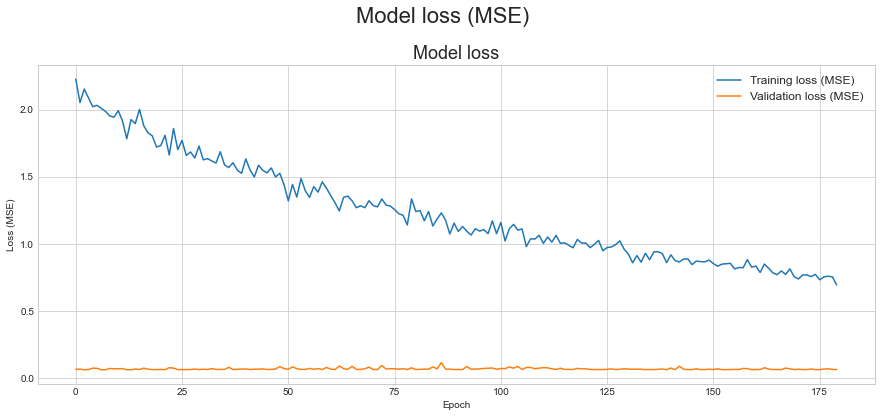

In [1119]:
from model import Transformer

epochs=200
lr=0.000001

model = Transformer(feature_size=len(feature_columns), use_mask=False)
train_losses, valid_losses = train_model(model, train_loader, valid_loader, epochs, lr)
plot_losses(train_losses[20:], valid_losses[20:])

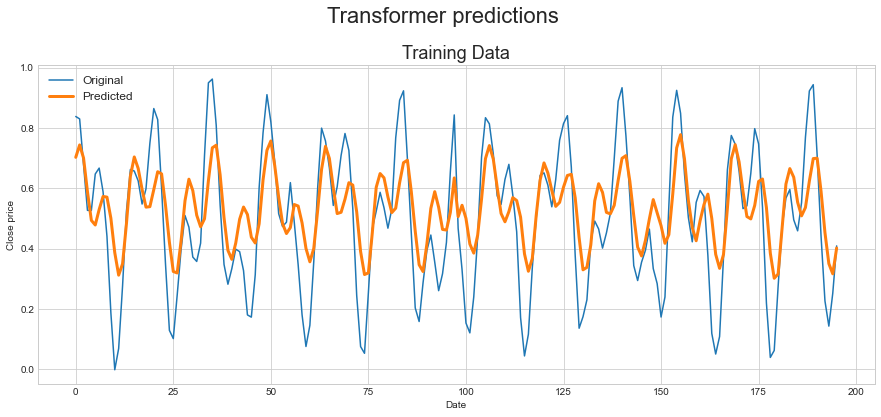

In [1120]:
original, predictions = predict(model, [valid_loader, test_loader])
draw_prediction(original, predictions)

## Training positional encoding

In [1158]:
# Data columns
print(f"Seq length: {train_len}")
print(data.columns)
# target_column = "Adj Close"
# feature_columns = ["Adj Close"]

target_column = "Adj Close"
feature_columns = ["Adj Close", "Volume"]

# target_column = "Return"
# feature_columns = ["Return", "Volume"]

# feature_columns = ["Return", "SRSI"]
# target_column = "Return"

# target_column = "Return Norm"
# feature_columns = ["Return Norm", "Volume"]

# target_column = "Return Norm"
# feature_columns = ["Return Norm", "Volume"]

# target_column = "Adj Close"
# feature_columns = ["Adj Close", "Volume Norm"]

# target_column = "Return Norm"
# feature_columns = ["Return Norm", "Volume Norm"]

# Scalers
scalers = [
    # (["Return"], MinMaxScaler()),
    (["Adj Close"], MinMaxScaler()),
    (["Volume"], MinMaxScaler()),
    # (["Volume Norm"], MinMaxScaler()),
    # (["VWAP"], MinMaxScaler()),
    # (["Return Norm"], None),
    # (["SRSI"], None),
]

Seq length: 7
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [1159]:
# Create loaders
train_loader, valid_loader, test_loader = create_loaders(data[feature_columns], target_column, scalers, valid_len, test_len, train_len=train_len)

Train data shape: (547, 2)
Valid data shape: (105, 2)
Test data shape: (105, 2)
Transform columns ['Adj Close']
Transform columns ['Volume']
Transform columns ['Adj Close']
Transform columns ['Volume']
Transform columns ['Adj Close']
Transform columns ['Volume']


2
Epoch 1
Train loss: 3.581082
Test loss: 1.738336
Epoch 2


/Users/nin/opt/anaconda3/envs/udacity/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/nin/opt/anaconda3/envs/udacity/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train loss: 2.878076
Test loss: 1.221133
Epoch 3
Train loss: 2.878505
Test loss: 0.976189
Epoch 4
Train loss: 2.453910
Test loss: 1.024959
Epoch 5
Train loss: 2.521042
Test loss: 0.551270
Epoch 6
Train loss: 2.679011
Test loss: 0.236132
Epoch 7
Train loss: 2.504384
Test loss: 0.304153
Epoch 8
Train loss: 1.954500
Test loss: 0.183060
Epoch 9
Train loss: 2.369487
Test loss: 0.119829
Epoch 10
Train loss: 2.328114
Test loss: 0.095089
Epoch 11
Train loss: 2.304837
Test loss: 0.127339
Epoch 12
Train loss: 1.842168
Test loss: 0.470240
Epoch 13
Train loss: 1.777858
Test loss: 0.356555
Epoch 14
Train loss: 2.024629
Test loss: 0.256356
Epoch 15
Train loss: 2.048870
Test loss: 0.110877
Epoch 16
Train loss: 1.936901
Test loss: 0.114341
Epoch 17
Train loss: 2.099589
Test loss: 0.126958
Epoch 18
Train loss: 1.835500
Test loss: 0.110430
Epoch 19
Train loss: 1.948548
Test loss: 0.073732
Epoch 20
Train loss: 1.720680
Test loss: 0.051221
Epoch 21
Train loss: 1.802659
Test loss: 0.049767
Epoch 22
Train l

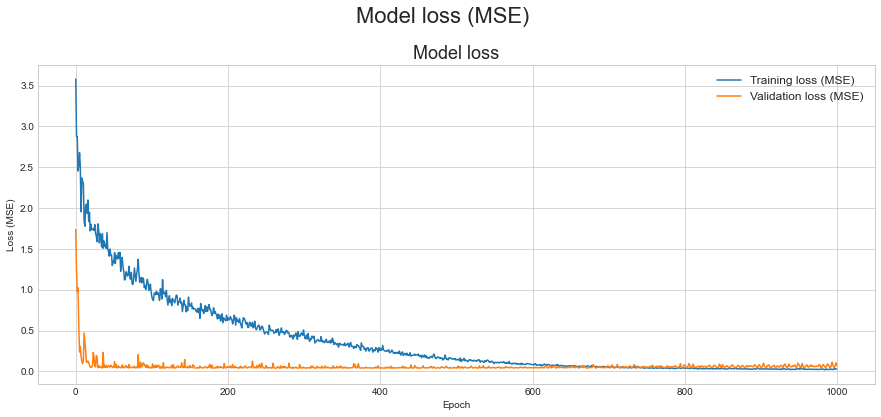

In [1160]:
from model import TransformerPos
## Best parameters
# Volume, price
# epochs=200
# lr=0.0000001
# use_mask=False

# On smlall data mask works bad

epochs=1000
# lr=0.000001
lr=0.00001

print(len(feature_columns))
model = TransformerPos(len(feature_columns), seq_len = train_len, dropout=0.2, use_mask=True)
train_losses, valid_losses = train_model(model, train_loader, valid_loader, epochs, lr)
# plot_losses(train_losses[20:], valid_losses[20:])
plot_losses(train_losses, valid_losses)

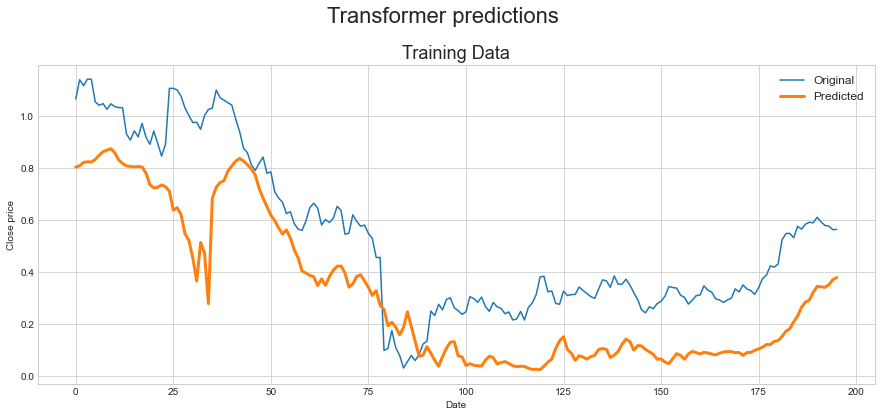

In [1163]:
original, predictions = predict(model, [valid_loader, test_loader])
draw_prediction(original, predictions)

## Transformer Time2Vector

In [1150]:
# Data columns
print(data.columns)
# target_column = "Adj Close"
# feature_columns = ["Adj Close"]

target_column = "Adj Close"
feature_columns = ["Adj Close", "Volume"]

# target_column = "Return"
# feature_columns = ["Return", "Volume"]

# target_column = "Return Norm"
# feature_columns = ["Return Norm", "Volume"]

# target_column = "Adj Close"
# feature_columns = ["Adj Close", "Volume Norm"]

# target_column = "Return Norm"
# feature_columns = ["Return Norm", "Volume Norm"]

# target_column = "Adj Close"
# feature_columns = ["Adj Close", "Volume", "Return"]

# Scalers
scalers = [
    (["Adj Close"], MinMaxScaler()),
    (["Volume"], MinMaxScaler()),
    # (["Return"], MinMaxScaler()),
    # (["Return Norm"], None),
]

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [1151]:
# Create loaders
train_loader, valid_loader, test_loader = create_loaders(data[feature_columns], target_column, scalers, valid_len, test_len)

Train data shape: (547, 2)
Valid data shape: (105, 2)
Test data shape: (105, 2)
Transform columns ['Adj Close']
Transform columns ['Volume']
Transform columns ['Adj Close']
Transform columns ['Volume']
Transform columns ['Adj Close']
Transform columns ['Volume']


Epoch 1
Train loss: 4.273522


/Users/nin/opt/anaconda3/envs/udacity/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/nin/opt/anaconda3/envs/udacity/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test loss: 1.590075
Epoch 2
Train loss: 3.059510
Test loss: 0.518368
Epoch 3
Train loss: 2.906335
Test loss: 0.742355
Epoch 4
Train loss: 3.003229
Test loss: 2.419796
Epoch 5
Train loss: 3.591032
Test loss: 0.312344
Epoch 6
Train loss: 2.374207
Test loss: 0.203963
Epoch 7
Train loss: 2.931190
Test loss: 0.680587
Epoch 8
Train loss: 2.429584
Test loss: 0.720049
Epoch 9
Train loss: 2.904576
Test loss: 0.196012
Epoch 10
Train loss: 2.123676
Test loss: 0.133016
Epoch 11
Train loss: 2.365996
Test loss: 0.281669
Epoch 12
Train loss: 2.040053
Test loss: 0.348509
Epoch 13
Train loss: 2.270005
Test loss: 0.068357
Epoch 14
Train loss: 1.905599
Test loss: 0.120960
Epoch 15
Train loss: 1.896912
Test loss: 0.110659
Epoch 16
Train loss: 1.896928
Test loss: 0.177089
Epoch 17
Train loss: 2.031454
Test loss: 0.110769
Epoch 18
Train loss: 1.853570
Test loss: 0.153574
Epoch 19
Train loss: 2.108568
Test loss: 0.077000
Epoch 20
Train loss: 1.957607
Test loss: 0.225099
Epoch 21
Train loss: 1.850262
Test los

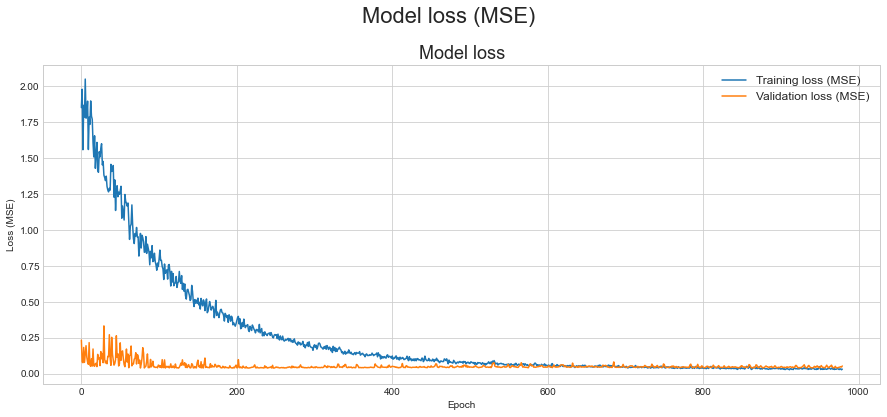

In [1156]:
from model import TransformerTime2Vec
# lr=0.0000001 - best
# lr=0.000001 - 0.000005 - best for generated data
# On small data has poor performance
epochs=1000
lr=0.00001

# TODO synchronize positional and time2vec encodding between samples.
model = TransformerTime2Vec(feature_size=len(feature_columns), use_mask=True)
train_losses, valid_losses = train_model(model, train_loader, valid_loader, epochs, lr)
plot_losses(train_losses[20:], valid_losses[20:])

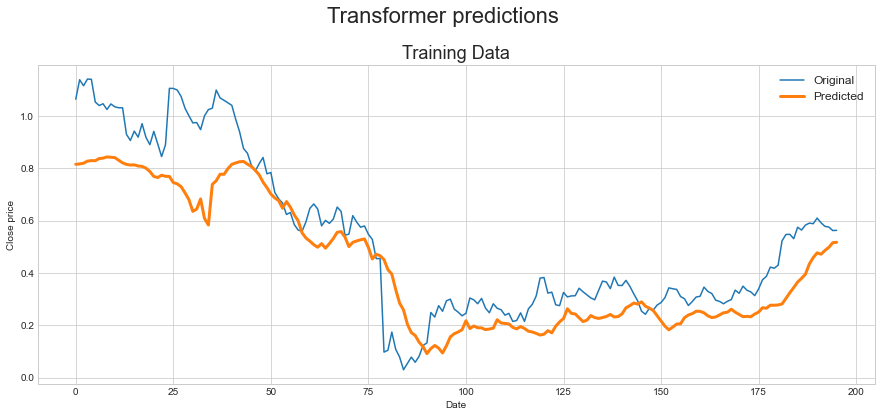

In [1157]:
original, predictions = predict(model, [valid_loader, test_loader])
draw_prediction(original, predictions)